In [ ]:
# Team Member: Zhengxuan Dong, Xiaoyan Zhou
# This project is used to recognize an image is a flower or not
# We build a CNN to do this job
# First we generate the training dataset
# Second training the CNN with training dataset
# Then test the CNN with test sample

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
from torchvision import transforms
import dataset
from skimage import transform,data
from tqdm import tqdm
import glob
import pickle
import torch.utils.data as data
import torch.nn.functional as F
%matplotlib inline

In [2]:
# define convolutional neural network
class single_conv(nn.Module):
    #'''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_ch)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.down = nn.MaxPool2d(2,stride=2)      # use nn.MaxPool2d( )
        self.conv =single_conv(in_ch,out_ch)                     # use previously defined single_cov
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv =nn.Conv2d(in_ch,out_ch,3,padding=1)    # Use nn.Conv2D( ) since we do not need to do batch norm and relu at this layer

    def forward(self, x):
        x = self.conv(x)
        return x


In [3]:
# define fully-connected layer
class fullyconnect(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(fullyconnect, self).__init__()
        self.fullyconnect =nn.Linear(in_ch, out_ch)
    def forward(self, x):
        x = self.fullyconnect(x)
        return x

In [4]:
# build a network with 3 convolutional layers and 2 fully connected layers
class CNN_Net(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels, 16) # conv2d +  batchnorm + relu
        self.down1 = down(16, 32)                 # maxpool2d + conv2d + batchnorm + relu
        self.down2 = down(32, 32)                 # maxpool2d + conv2d + batchnorm + relu
        #self.outc = outconv(32,n_classes)
        self.ful1 = fullyconnect(32*225,1000)
        self.ful2 = fullyconnect(1000,1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = x3#self.outc(x3)
        x5 = x4.reshape((32*225))
        x6 = self.ful1(x5)
        x7 = self.ful2(x6)
        return F.sigmoid(x7)

In [5]:

# train data
def get_train_val(image_paths):
    img_paths_dic = {}
    len_data = len(image_paths)
    for i in range(len(image_paths)):
        img_paths_dic[os.path.basename(image_paths[i])[:-4]] = image_paths[i]
    
    img_mask_list = []
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key]))
        
    train_img_paths = img_mask_list 
    return train_img_paths

In [6]:
def preprocess_image(image_img_paths):
    img_prob_list = []
    
    for i in tqdm(range(len(image_img_paths))):
        img = np.array(Image.open(image_img_paths[i]), np.float32) / 255.0 
        k=os.path.basename(image_paths[i])[1]
        
        if k=='0':
            prob = np.array([1]).astype(float)
        elif k=='1':
            prob = np.array([0]).astype(float)
        
        
        img_prob_list.append((img,prob))
    print(len(image_img_paths))
    print(len(img_prob_list))
    return img_prob_list

In [7]:
def pickle_store(file_name,save_data):
    fileObj = open(file_name,'wb')
    pickle.dump(save_data,fileObj)
    fileObj.close()

original image shape: (60, 60, 3)
total len: 3956
l0b0
3956


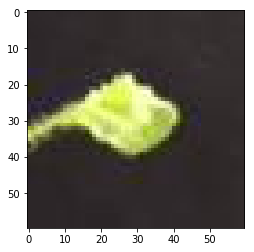

In [8]:
#loading data
image_paths = glob.glob("cir01_train2/*.jpg")
print('original image shape: {}'.format(np.array(Image.open(image_paths[0])).shape))
plt.imshow(Image.open(image_paths[0]))
train_img_paths = get_train_val(image_paths)
print('total len:', len(train_img_paths))
print(os.path.basename(image_paths[0])[:-4])
print(len(train_img_paths))

In [9]:
train_img_prob_save_path = './train_img_prob8.pickle'
if os.path.exists(train_img_prob_save_path):
    with open(train_img_prob_save_path,'rb') as f:
        train_img_prob = pickle.load(f)
    f.close()
else:
    train_img_prob = preprocess_image(train_img_paths)
    pickle_store(train_img_prob_save_path,train_img_prob)
print('train len: {}'.format(len(train_img_prob)))
#print(train_img_prob[1])

train len: 3956


In [10]:
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label
            
            return {'img': img_flip, 'label': label_flip}

In [11]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.DoubleTensor),
                'label': label}

In [12]:
class CustomDataset(data.Dataset):
    def __init__(self, image_probs, transforms=None):   # initial logic happens like transform

        self.image_probs = image_probs
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_probs)
    
    def __getitem__(self, index):

        image = self.image_probs[index][0] # H, W, C
        prob = self.image_probs[index][1]
        
        image = np.transpose(image, axes=[2, 0, 1]) # C, H, W
        
        sample = {'img': image, 'label': prob}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_prob, transforms=transforms.Compose([Flip(),ToTensor()]))

print(len(train_dataset))

[0.]
3956


In [13]:

# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 2 # i.e, 4
batch_size = 1 # i.e, 16
lr = 0.001       # i.e, 0.01
N_train = len(train_img_prob)
model_save_path = './model/'  # directory to same the model after each epoch. 
net = UNet(3,1).double()


optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=0.0005)



# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.BCELoss()



# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images for training and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    epoch_loss = 0
    
    for i, b in enumerate(train_loader):
        # Get images and probility from each batch
        imgs = b['img']
        true_prob = b['label']

        # Feed your images into the network
        prob_pred = net(imgs)
        print(prob_pred)
        print(true_prob)

        loss = criterion(prob_pred,true_prob)
        epoch_loss += loss.item()

        print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        # x.grad += dloss/dx
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        # x += -lr * x.grad
        optimizer.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))

    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))
    

Starting epoch 1/2.


C:\Users\ThinkPadT480s\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.5675], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)


C:\Users\ThinkPadT480s\Anaconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0.0000 --- loss: 0.566506
tensor([0.4755], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0003 --- loss: 0.645342
tensor([0.5229], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0005 --- loss: 0.740098
tensor([0.4244], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0008 --- loss: 0.552400
tensor([0.3160], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0010 --- loss: 0.379869
tensor([0.4882], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0013 --- loss: 0.716936
tensor([0.2145], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0015 --- loss: 0.241372
tensor([0.4576], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0018 --- loss: 0.781804
tensor([0.7049], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype

tensor([0.4925], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0326 --- loss: 0.678327
tensor([0.0016], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0329 --- loss: 0.001574
tensor([0.0039], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0331 --- loss: 0.003917
tensor([0.0007], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0334 --- loss: 0.000710
tensor([0.0011], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0336 --- loss: 0.001113
tensor([0.9976], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0339 --- loss: 0.002368
tensor([0.9978], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0341 --- loss: 0.002184
tensor([0.0003], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0344 ---

0.0647 --- loss: 0.000242
tensor([1.4830e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0650 --- loss: 0.000015
tensor([1.4794e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0652 --- loss: 0.000015
tensor([0.9783], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0655 --- loss: 0.021945
tensor([0.0003], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0657 --- loss: 0.000253
tensor([2.5880e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0660 --- loss: 0.000026
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0662 --- loss: 0.000158
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0665 --- loss: 0.000082
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([

0.0971 --- loss: 0.000376
tensor([0.9992], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0973 --- loss: 0.000765
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0976 --- loss: 0.000002
tensor([0.9986], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0978 --- loss: 0.001374
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0981 --- loss: 0.000039
tensor([5.4377e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0983 --- loss: 0.000054
tensor([0.9961], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0986 --- loss: 0.003939
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0988 --- loss: 0.000215
tensor([0.0069], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], d

tensor([[0.]], dtype=torch.float64)
0.1294 --- loss: 0.000189
tensor([0.0008], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1297 --- loss: 0.000783
tensor([5.4153e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1299 --- loss: 0.000005
tensor([0.9946], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1302 --- loss: 0.005456
tensor([0.9993], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1304 --- loss: 0.000695
tensor([7.6329e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1307 --- loss: 0.000001
tensor([0.9988], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1309 --- loss: 0.001209
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1312 --- loss: 0.000122
tensor([0.9988], dtype=torch.float64, gra

tensor([0.0620], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1618 --- loss: 0.064005
tensor([0.9995], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1620 --- loss: 0.000472
tensor([0.1923], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1623 --- loss: 0.213568
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1625 --- loss: 0.000256
tensor([0.9397], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1628 --- loss: 0.062208
tensor([1.7733e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1630 --- loss: 0.000002
tensor([0.0612], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1633 --- loss: 0.063194
tensor([1.9935e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.

tensor([0.0039], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1941 --- loss: 0.003872
tensor([0.0004], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1944 --- loss: 0.000406
tensor([8.8694e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1946 --- loss: 0.000000
tensor([0.0213], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1949 --- loss: 0.021521
tensor([0.0028], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1951 --- loss: 0.002813
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1954 --- loss: 0.000025
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1957 --- loss: 0.000023
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1959

tensor([[0.]], dtype=torch.float64)
0.2262 --- loss: 0.000753
tensor([0.9931], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2265 --- loss: 0.006955
tensor([0.9945], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2267 --- loss: 0.005530
tensor([0.0021], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2270 --- loss: 0.002076
tensor([0.0039], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2272 --- loss: 0.003885
tensor([0.9975], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2275 --- loss: 0.002524
tensor([0.0023], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2278 --- loss: 0.002282
tensor([0.9888], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2280 --- loss: 0.011286
tensor([2.9746e-05], dtype=torch.float64, grad_fn

tensor([0.9988], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2586 --- loss: 0.001217
tensor([1.0045e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2588 --- loss: 0.000010
tensor([0.9967], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2591 --- loss: 0.003313
tensor([2.2965e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2594 --- loss: 0.000000
tensor([1.1090e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2596 --- loss: 0.000000
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2599 --- loss: 0.000291
tensor([0.9989], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2601 --- loss: 0.001077
tensor([5.9873e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([0.0025], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2907 --- loss: 0.002507
tensor([3.1622e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2910 --- loss: 0.000000
tensor([5.9970e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2912 --- loss: 0.000000
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2915 --- loss: 0.000250
tensor([3.4067e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2917 --- loss: 0.000000
tensor([2.4221e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2920 --- loss: 0.000024
tensor([0.9979], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2922 --- loss: 0.002081
tensor([0.9994], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.flo

tensor([[0.]], dtype=torch.float64)
0.3225 --- loss: 0.000120
tensor([1.5825e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3228 --- loss: 0.000000
tensor([0.9855], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3231 --- loss: 0.014617
tensor([1.4853e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3233 --- loss: 0.000015
tensor([3.5353e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3236 --- loss: 0.000004
tensor([0.0003], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3238 --- loss: 0.000281
tensor([4.6609e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3241 --- loss: 0.000005
tensor([2.5299e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3243 --- loss: 0.000025
tensor([0.9195], dtype=torch.

0.3547 --- loss: 0.000401
tensor([0.0638], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3549 --- loss: 0.065947
tensor([0.0008], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3552 --- loss: 0.000805
tensor([3.6602e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3554 --- loss: 0.000037
tensor([0.9938], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3557 --- loss: 0.006244
tensor([0.0005], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3559 --- loss: 0.000490
tensor([0.0006], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3562 --- loss: 0.000613
tensor([0.0013], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3564 --- loss: 0.001274
tensor([0.0031], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], d

tensor([9.9986e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3870 --- loss: 0.000010
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3873 --- loss: 0.000332
tensor([0.9989], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3875 --- loss: 0.001085
tensor([3.8576e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3878 --- loss: 0.000004
tensor([0.9986], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3880 --- loss: 0.001362
tensor([0.9995], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3883 --- loss: 0.000507
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3885 --- loss: 0.000278
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.

tensor([1.8285e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4191 --- loss: 0.000002
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4194 --- loss: 0.000203
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4196 --- loss: 0.000162
tensor([0.9995], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4199 --- loss: 0.000492
tensor([7.1046e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4201 --- loss: 0.000071
tensor([3.6246e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4204 --- loss: 0.000036
tensor([0.9989], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4206 --- loss: 0.001116
tensor([0.0065], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4512 --- loss: 0.000204
tensor([7.6093e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4515 --- loss: 0.000000
tensor([3.9368e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4517 --- loss: 0.000004
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4520 --- loss: 0.000146
tensor([1.2618e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4522 --- loss: 0.000000
tensor([4.6427e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4525 --- loss: 0.000046
tensor([6.3854e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4527 --- loss: 0.000064
tensor([6.7987e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([[0.]], dtype=torch.float64)
0.4831 --- loss: 0.000145
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4833 --- loss: 0.000060
tensor([3.5235e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4836 --- loss: 0.000000
tensor([0.9983], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4838 --- loss: 0.001734
tensor([9.1517e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4841 --- loss: 0.000009
tensor([7.1012e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4843 --- loss: 0.000071
tensor([0.9993], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4846 --- loss: 0.000684
tensor([0.8699], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4848 --- loss: 0.139420
tensor([7.7883e-07], dtype=torch.floa

tensor([[0.]], dtype=torch.float64)
0.5152 --- loss: 0.000000
tensor([4.8579e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5154 --- loss: 0.000005
tensor([0.0008], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5157 --- loss: 0.000795
tensor([0.9995], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5159 --- loss: 0.000472
tensor([5.4063e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5162 --- loss: 0.000054
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5164 --- loss: 0.000025
tensor([6.9171e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5167 --- loss: 0.000000
tensor([3.2142e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5169 --- loss: 0.000003
tensor([2.4933e-09], dtype=torch.

tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5473 --- loss: 0.000115
tensor([9.8318e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5475 --- loss: 0.000010
tensor([0.0029], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5478 --- loss: 0.002898
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5480 --- loss: 0.000194
tensor([0.9996], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5483 --- loss: 0.000391
tensor([1.0542e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5485 --- loss: 0.000001
tensor([3.3401e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5488 --- loss: 0.000033
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64

tensor([[1.]], dtype=torch.float64)
0.5791 --- loss: 0.003787
tensor([2.3084e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5794 --- loss: 0.000000
tensor([1.0209e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5796 --- loss: 0.000001
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5799 --- loss: 0.000221
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5801 --- loss: 0.000037
tensor([0.9908], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5804 --- loss: 0.009282
tensor([1.4916e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5806 --- loss: 0.000000
tensor([1.2855e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5809 --- loss: 0.000000
tensor([2.1442e-05], dtype=torch.

tensor([[0.]], dtype=torch.float64)
0.6112 --- loss: 0.000115
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6115 --- loss: 0.000203
tensor([9.2776e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6117 --- loss: 0.000001
tensor([1.8974e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6120 --- loss: 0.000000
tensor([0.9993], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6122 --- loss: 0.000750
tensor([8.6862e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6125 --- loss: 0.000000
tensor([0.7629], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6127 --- loss: 1.439154
tensor([5.5891e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6130 --- loss: 0.000056
tensor([1.2643e-05], dtype=torch.

tensor([2.4898e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6433 --- loss: 0.000000
tensor([0.9897], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6436 --- loss: 0.010304
tensor([7.9196e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6438 --- loss: 0.000000
tensor([8.2642e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6441 --- loss: 0.000083
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6443 --- loss: 0.000050
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6446 --- loss: 0.000001
tensor([1.8095e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6448 --- loss: 0.000002
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.flo

tensor([4.1533e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6752 --- loss: 0.000000
tensor([2.0253e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6754 --- loss: 0.000000
tensor([4.2214e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6757 --- loss: 0.000000
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6759 --- loss: 0.000090
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6762 --- loss: 0.000170
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6764 --- loss: 0.000013
tensor([2.4105e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6767 --- loss: 0.000000
tensor([5.3053e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

0.7070 --- loss: 0.000005
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7073 --- loss: 0.000012
tensor([0.0018], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7075 --- loss: 0.001788
tensor([0.0051], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7078 --- loss: 0.005067
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7080 --- loss: 0.000008
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7083 --- loss: 0.000015
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7085 --- loss: 0.000133
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7088 --- loss: 0.000012
tensor([7.4769e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], d

tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7394 --- loss: 0.000153
tensor([0.9986], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7396 --- loss: 0.001377
tensor([3.9669e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7399 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7401 --- loss: 0.000013
tensor([1.7808e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7404 --- loss: 0.000000
tensor([2.2272e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7406 --- loss: 0.000002
tensor([0.9967], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7409 --- loss: 0.003345
tensor([6.2050e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([4.5038e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7715 --- loss: 0.000000
tensor([9.9413e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7717 --- loss: 0.000010
tensor([0.0006], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7720 --- loss: 0.000572
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7722 --- loss: 0.000000
tensor([0.9993], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7725 --- loss: 0.000704
tensor([0.9988], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7728 --- loss: 0.001168
tensor([0.0004], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7730 --- loss: 0.000450
tensor([1.8568e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([[1.]], dtype=torch.float64)
0.8033 --- loss: 0.000006
tensor([0.0004], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8036 --- loss: 0.000378
tensor([1.2346e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8038 --- loss: 0.000001
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8041 --- loss: 0.000005
tensor([1.8183e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8043 --- loss: 0.000018
tensor([4.3318e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8046 --- loss: 0.000000
tensor([2.9162e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8049 --- loss: 0.000000
tensor([7.4155e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8051 --- loss: 0.000001
tensor([1.0000], dtype=torch.

tensor([2.6621e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8354 --- loss: 0.000003
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8357 --- loss: 0.000001
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8359 --- loss: 0.000194
tensor([0.0015], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8362 --- loss: 0.001485
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8365 --- loss: 0.000012
tensor([4.6334e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8367 --- loss: 0.000000
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8370 --- loss: 0.000145
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.

tensor([7.7208e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8673 --- loss: 0.000077
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8675 --- loss: 0.000001
tensor([1.2218e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8678 --- loss: 0.000000
tensor([2.5743e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8680 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8683 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8686 --- loss: 0.000001
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8688 --- loss: 0.000002
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64

tensor([2.0837e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8991 --- loss: 0.000002
tensor([0.0030], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8994 --- loss: 0.003018
tensor([0.0339], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8996 --- loss: 0.034449
tensor([0.0013], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8999 --- loss: 0.001264
tensor([0.0077], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9002 --- loss: 0.007701
tensor([2.5808e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9004 --- loss: 0.000000
tensor([0.0846], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9007 --- loss: 0.088379
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.

tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9310 --- loss: 0.000057
tensor([3.6491e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9312 --- loss: 0.000000
tensor([7.4219e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9315 --- loss: 0.000000
tensor([0.0201], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9317 --- loss: 0.020263
tensor([2.7906e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9320 --- loss: 0.000028
tensor([3.4313e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9323 --- loss: 0.000000
tensor([2.7215e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9325 --- loss: 0.000027
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch

tensor([1.0969e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9628 --- loss: 0.000011
tensor([0.9990], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9631 --- loss: 0.001002
tensor([3.7960e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9633 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9636 --- loss: 0.000035
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9639 --- loss: 0.000122
tensor([2.2041e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9641 --- loss: 0.000000
tensor([1.4902e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9644 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.flo

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9947 --- loss: 0.000003
tensor([0.9991], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9949 --- loss: 0.000918
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9952 --- loss: 0.000014
tensor([7.7894e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9954 --- loss: 0.000000
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9957 --- loss: 0.000298
tensor([5.2344e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9960 --- loss: 0.000000
tensor([5.7669e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9962 --- loss: 0.000000
tensor([1.3826e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([[1.]], dtype=torch.float64)
0.0263 --- loss: 0.000313
tensor([2.0384e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0265 --- loss: 0.000020
tensor([2.1641e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0268 --- loss: 0.000022
tensor([6.0902e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0270 --- loss: 0.000000
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0273 --- loss: 0.000130
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0276 --- loss: 0.000057
tensor([4.0707e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0278 --- loss: 0.000000
tensor([5.4575e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0281 --- loss: 0.000000
tensor([0.0002], dtype=torch.

tensor([2.6723e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0584 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0586 --- loss: 0.000001
tensor([2.4479e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0589 --- loss: 0.000000
tensor([9.7435e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0592 --- loss: 0.000000
tensor([2.9759e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0594 --- loss: 0.000030
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0597 --- loss: 0.000004
tensor([8.7598e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0599 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch

tensor([6.6963e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0902 --- loss: 0.000001
tensor([5.8240e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0905 --- loss: 0.000000
tensor([9.6309e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0907 --- loss: 0.000000
tensor([1.0669e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0910 --- loss: 0.000000
tensor([0.9982], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0913 --- loss: 0.001771
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.0915 --- loss: 0.000004
tensor([4.7678e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.0918 --- loss: 0.000000
tensor([4.6224e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1221 --- loss: 0.000146
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1223 --- loss: 0.000004
tensor([4.3949e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1226 --- loss: 0.000000
tensor([7.8077e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1229 --- loss: 0.000000
tensor([6.0438e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1231 --- loss: 0.000000
tensor([3.7207e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1234 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1236 --- loss: 0.000002
tensor([5.1266e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

tensor([5.7014e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1539 --- loss: 0.000001
tensor([4.0727e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1542 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1544 --- loss: 0.000001
tensor([2.7102e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1547 --- loss: 0.000000
tensor([6.9346e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1550 --- loss: 0.000000
tensor([1.4872e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1552 --- loss: 0.000000
tensor([2.5378e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1555 --- loss: 0.000000
tensor([9.4484e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dty

tensor([1.0139e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1858 --- loss: 0.000010
tensor([1.0545e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1860 --- loss: 0.000000
tensor([2.0413e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1863 --- loss: 0.000020
tensor([4.5946e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1866 --- loss: 0.000000
tensor([0.0003], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1868 --- loss: 0.000250
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.1871 --- loss: 0.000002
tensor([7.5117e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.1873 --- loss: 0.000075
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch

tensor([[0.]], dtype=torch.float64)
0.2176 --- loss: 0.000000
tensor([2.4915e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2179 --- loss: 0.000002
tensor([1.9070e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2181 --- loss: 0.000000
tensor([0.9979], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2184 --- loss: 0.002056
tensor([8.1740e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2187 --- loss: 0.000001
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2189 --- loss: 0.000014
tensor([1.1397e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2192 --- loss: 0.000000
tensor([1.8142e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2194 --- loss: 0.000000
tensor([2.3517e-06], dtype=to

0.2495 --- loss: 0.000000
tensor([6.7916e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2497 --- loss: 0.000001
tensor([1.0876e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2500 --- loss: 0.000000
tensor([1.2482e-14], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2503 --- loss: 0.000000
tensor([0.9873], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2505 --- loss: 0.012777
tensor([2.7874e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2508 --- loss: 0.000028
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2510 --- loss: 0.000003
tensor([2.2296e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2513 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)


tensor([8.1900e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2816 --- loss: 0.000008
tensor([2.0125e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2819 --- loss: 0.000000
tensor([2.1135e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2821 --- loss: 0.000002
tensor([7.7746e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2824 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2826 --- loss: 0.000013
tensor([3.9802e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.2829 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.2831 --- loss: 0.000024
tensor([1.3422e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([1.8215e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3134 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3137 --- loss: 0.000013
tensor([2.3409e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3140 --- loss: 0.000000
tensor([1.5921e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3142 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3145 --- loss: 0.000032
tensor([1.2175e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3147 --- loss: 0.000012
tensor([6.6452e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3150 --- loss: 0.000000
tensor([3.5722e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([1.2505e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3453 --- loss: 0.000000
tensor([6.3165e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3456 --- loss: 0.000000
tensor([2.1769e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3458 --- loss: 0.000000
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3461 --- loss: 0.000119
tensor([6.8744e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3463 --- loss: 0.000000
tensor([1.5345e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3466 --- loss: 0.000015
tensor([1.5678e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3468 --- loss: 0.000000
tensor([4.0407e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dty

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3771 --- loss: 0.000011
tensor([1.0366e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3774 --- loss: 0.000000
tensor([0.9995], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3777 --- loss: 0.000456
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3779 --- loss: 0.000002
tensor([0.0004], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3782 --- loss: 0.000412
tensor([1.9695e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.3784 --- loss: 0.000020
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.3787 --- loss: 0.000064
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.

tensor([6.3387e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4090 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4093 --- loss: 0.000005
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4095 --- loss: 0.000001
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4098 --- loss: 0.000029
tensor([9.4659e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4100 --- loss: 0.000000
tensor([8.9554e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4103 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4105 --- loss: 0.000007
tensor([7.4187e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4408 --- loss: 0.000000
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4411 --- loss: 0.000162
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4414 --- loss: 0.000056
tensor([5.5978e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4416 --- loss: 0.000056
tensor([2.1270e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4419 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4421 --- loss: 0.000004
tensor([2.7565e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4424 --- loss: 0.000003
tensor([3.6722e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([6.9216e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4727 --- loss: 0.000000
tensor([6.6846e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4730 --- loss: 0.000001
tensor([9.8427e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4732 --- loss: 0.000000
tensor([0.9977], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4735 --- loss: 0.002269
tensor([5.2998e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4737 --- loss: 0.000000
tensor([0.9980], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.4740 --- loss: 0.001954
tensor([2.8123e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.4742 --- loss: 0.000000
tensor([5.5110e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([1.7734e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5046 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5048 --- loss: 0.000003
tensor([1.8179e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5051 --- loss: 0.000000
tensor([1.0113e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5053 --- loss: 0.000000
tensor([0.9951], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5056 --- loss: 0.004922
tensor([6.0068e-14], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5058 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5061 --- loss: 0.000003
tensor([1.8622e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

tensor([1.1287e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5364 --- loss: 0.000000
tensor([4.1182e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5367 --- loss: 0.000000
tensor([6.3657e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5369 --- loss: 0.000000
tensor([2.0481e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5372 --- loss: 0.000000
tensor([2.8593e-14], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5374 --- loss: 0.000000
tensor([0.9946], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5377 --- loss: 0.005366
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5379 --- loss: 0.000002
tensor([1.5602e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([2.1146e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5683 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5685 --- loss: 0.000004
tensor([4.0486e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5688 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5690 --- loss: 0.000000
tensor([5.3472e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5693 --- loss: 0.000000
tensor([5.3114e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.5695 --- loss: 0.000000
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.5698 --- loss: 0.000345
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.flo

tensor([2.3499e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6001 --- loss: 0.000000
tensor([0.9991], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6004 --- loss: 0.000884
tensor([9.9808e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6006 --- loss: 0.000000
tensor([7.4929e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6009 --- loss: 0.000000
tensor([7.1466e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6011 --- loss: 0.000000
tensor([0.9976], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6014 --- loss: 0.002371
tensor([6.2396e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6016 --- loss: 0.000000
tensor([1.0457e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6320 --- loss: 0.000000
tensor([9.6812e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6322 --- loss: 0.000000
tensor([5.0179e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6325 --- loss: 0.000000
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6327 --- loss: 0.000056
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6330 --- loss: 0.000099
tensor([0.9997], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6332 --- loss: 0.000314
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6335 --- loss: 0.000000
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6638 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6641 --- loss: 0.000005
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6643 --- loss: 0.000000
tensor([1.7145e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6646 --- loss: 0.000017
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6648 --- loss: 0.000000
tensor([1.8476e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6651 --- loss: 0.000002
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6653 --- loss: 0.000002
tensor([3.5932e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([5.3434e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6957 --- loss: 0.000000
tensor([1.3794e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6959 --- loss: 0.000001
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6962 --- loss: 0.000000
tensor([3.9730e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6964 --- loss: 0.000000
tensor([1.3362e-15], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.6967 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6969 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.6972 --- loss: 0.000017
tensor([1.9348e-15], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

tensor([4.6093e-14], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7275 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7278 --- loss: 0.000001
tensor([1.7141e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7280 --- loss: 0.000000
tensor([4.6218e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7283 --- loss: 0.000000
tensor([8.2117e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7285 --- loss: 0.000008
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7288 --- loss: 0.000001
tensor([1.3725e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7290 --- loss: 0.000000
tensor([8.2013e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7594 --- loss: 0.000008
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7596 --- loss: 0.000072
tensor([0.0010], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7599 --- loss: 0.000950
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7601 --- loss: 0.000000
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7604 --- loss: 0.000210
tensor([6.5058e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7606 --- loss: 0.000000
tensor([1.8535e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7609 --- loss: 0.000000
tensor([5.1871e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7915 --- loss: 0.000003
tensor([1.1968e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7917 --- loss: 0.000000
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7920 --- loss: 0.000105
tensor([2.8863e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7922 --- loss: 0.000000
tensor([1.7893e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7925 --- loss: 0.000018
tensor([1.3555e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.7927 --- loss: 0.000000
tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.7930 --- loss: 0.000237
tensor([2.1853e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

tensor([4.5350e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8233 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8236 --- loss: 0.000002
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8238 --- loss: 0.000167
tensor([4.3905e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8241 --- loss: 0.000000
tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8243 --- loss: 0.000057
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8246 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8248 --- loss: 0.000001
tensor([7.9245e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([0.9998], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8552 --- loss: 0.000232
tensor([4.1138e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8554 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8557 --- loss: 0.000019
tensor([1.0115e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8559 --- loss: 0.000000
tensor([5.0084e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8562 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8564 --- loss: 0.000001
tensor([8.1747e-06], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8567 --- loss: 0.000008
tensor([0.0002], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.flo

tensor([0.9999], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8870 --- loss: 0.000054
tensor([3.2760e-15], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8873 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8875 --- loss: 0.000013
tensor([3.4818e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8878 --- loss: 0.000035
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.8880 --- loss: 0.000034
tensor([3.3895e-10], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8883 --- loss: 0.000000
tensor([5.0799e-14], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.8885 --- loss: 0.000000
tensor([7.3881e-13], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9189 --- loss: 0.000000
tensor([1.3434e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9191 --- loss: 0.000000
tensor([1.0023e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9194 --- loss: 0.000010
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9196 --- loss: 0.000006
tensor([1.3089e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9199 --- loss: 0.000000
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9201 --- loss: 0.000137
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9204 --- loss: 0.000007
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64

tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9507 --- loss: 0.000000
tensor([0.9974], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9510 --- loss: 0.002573
tensor([2.5610e-05], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9512 --- loss: 0.000026
tensor([0.9818], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9515 --- loss: 0.018406
tensor([0.0001], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9517 --- loss: 0.000144
tensor([1.5509e-08], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9520 --- loss: 0.000000
tensor([0.9994], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9522 --- loss: 0.000645
tensor([1.0395e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64

tensor([1.1751e-12], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9826 --- loss: 0.000000
tensor([4.8533e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9828 --- loss: 0.000000
tensor([2.8413e-09], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9831 --- loss: 0.000000
tensor([2.4584e-07], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9833 --- loss: 0.000000
tensor([1.2321e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=torch.float64)
0.9836 --- loss: 0.000000
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9838 --- loss: 0.000005
tensor([1.0000], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[1.]], dtype=torch.float64)
0.9841 --- loss: 0.000022
tensor([6.2601e-11], dtype=torch.float64, grad_fn=<SigmoidBackward>)
tensor([[0.]], dtype=t

In [ ]:
# The loss converge to 0